In [2]:
import pandas as pd
import numpy as np
from com_var import *
from support_func import *
import wave_process
# import ta_feature
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import  *
from tensorflow.keras.callbacks import EarlyStopping
# from time_series import df_to_X_y2future,df_to_X_y2
from tradingview_ta import TA_Handler, Interval, Exchange
import yfinance as yf
import talib as ta



In [2]:

# def df_to_X_y2(df, window_size=12,nfuture=2):
#     k=df.reset_index()
#     df_as_np = df.to_numpy()
#     X = []
#     y = []
#     ko=0 if o==1 else o
#     xlast=[]
#     dates=[]
#     r=len(df_as_np)-window_size-nfuture+1 if nfuture>1 else len(df_as_np)-window_size
#     for i in range(r):
#         row = [r for r in df_as_np[i:i+window_size]]
#         X.append(row)
#         label =[r[ko] for r in df_as_np[i+window_size:i+window_size+nfuture]] if nfuture>1 else df_as_np[i+window_size][:ko]
#         xlast.append(df_as_np[i+window_size-1][3])
#         y.append(label)
#         date=k[v][i+window_size:i+window_size+nfuture].values if nfuture>1 else k[v][i+window_size]
#         dates.append(date)
#     X=np.asarray(X)
#     y=np.asarray(y)
    
#     print(f"hii X {X.shape}, y {y.shape}")
#     return X,y,dates,xlast

In [3]:
def df_to_X_y2(df, window_size=6):
    print(df.shape)
    k=df.reset_index()
    ko=o
    ko=0 if o==1 else o
    l= 0 if o==1 else 3
    

    df_as_np = df.to_numpy()
    dates=[]
    X = []
    y = []
    xlast=[]
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)

        label =[df_as_np[i+window_size][ko]] if o==1 else df_as_np[i+window_size][:ko]
        y.append(label)
        dates.append(k[v][i+window_size])
        xlast.append([row[-1][l]])
    X=np.asarray(X)
    y=np.asarray(y)
    
    print(f"hii X {X.shape}, y {y.shape}")
    return X,y,dates,xlast


In [4]:

def technicalIndicators(data):
    data["MA"]=ta.MA(data['Close'], timeperiod=14, matype=0)
    # data['Close_wave'],data['High_wave'],data['Low_wave'],\
    # data['Open_wave']=wave_process.denoising([data['Close'],data['High'],data['Low'],data['Open']])
    
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'], \
                                                                 fastperiod=7, slowperiod=14, signalperiod=5)
  
    # data['CCI14'] = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
   

    
    # data['ATR14'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    # data['NATR14']=ta.NATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data["DEMA"]=ta.DEMA(data['Close'], timeperiod=14)

    # data["BBupper"],data["BBmidle"],data["BBlower"]=ta.BBANDS(data['Close'], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
    data["EMA10"]=ta.EMA(data['Close'], timeperiod=10)
    data["EMA30"]=ta.EMA(data['Close'], timeperiod=30)
    data["MOM"] = ta.MOM(data['Close'], timeperiod=14)
    
    data['ROC']=ta.ROC(data['Close'], timeperiod=14)
    data['KAMA']=ta.KAMA(data['Close'], timeperiod=14)

    # data["WillR"]=ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)
    
    



    return data


In [5]:

def getdata(ticker):
# Get the data
    li=["Adj Close","Volume","Open","High","Low"] if o==1 else ["Adj Close","Volume"]
    data = yf.download(tickers=ticker+"=X",period="730d" ,interval="1h",progress=True)
    data=data.drop(li,axis=1)
    
    data=technicalIndicators(data)
    # data cleaning 
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    validation_size1=round(data.shape[0]/6)
    test_size1=validation_size1
    test_size1

    df_train =data[:- validation_size1*2].copy(deep=True)
    df_validation = data[- validation_size1*2 :- test_size1].copy(deep=True)
    df_test = data[- test_size1 :].copy(deep=True)
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_validation.shape}, df_test.shape {df_test.shape}')
    return df_train,df_validation,df_test,data





In [6]:

def preprocess(df_train,df_test,df_validation,scaler = MinMaxScaler()):

    
    train_values=df_train.iloc[:,:].copy(deep=True)
    val_values=df_validation.iloc[:,:].copy(deep=True)
    test_values=df_test.iloc[:,:].copy(deep=True)
    train_values.iloc[:,:] = scaler.fit_transform(train_values)[:,:]
    val_values.iloc[:,:]=scaler.fit_transform(val_values)[:,:]
    test_values.iloc[:,:]=scaler.fit_transform(test_values)[:,:]
    X,y,dx,xtl=df_to_X_y2(train_values,window_size)
    x_val,y_val,dv,xvl=df_to_X_y2(val_values,window_size)
    x_test,y_test,dt,xtsl=df_to_X_y2(test_values,window_size)

    return X,y,x_val,y_val,x_test,y_test,train_values,val_values,test_values,scaler,dx,dv,dt,xtsl


In [7]:
import time
import os.path


  
# # store starting time
# begin = time.time()
ticker="gbpusd"
df_train,df_val,df_test,data=getdata(ticker)
epochs = 10
np.random.seed(seed)
tf.random.set_seed(seed)


xtrain,ytrain,xval,yval,xtest,ytest,ttable,valtble,testtble,scaler,dx,dv,dt,xtsl=preprocess(df_train=df_train,df_validation=df_val,df_test=df_test)

maincolumn=xtrain.shape[2]


[*********************100%***********************]  1 of 1 completed
df_train.shape (11520, 11), df_validation.shape (2880, 11), df_test.shape (2880, 11)
(11520, 11)
hii X (11400, 120, 11), y (11400, 1)
(2880, 11)
hii X (2760, 120, 11), y (2760, 1)
(2880, 11)
hii X (2760, 120, 11), y (2760, 1)


In [8]:
from tensorflow import keras
from tensorflow.keras import layers
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [9]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,o=1
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(o)(x)
    return keras.Model(inputs, outputs)


In [10]:
def getrocketmodel(xtrain,o):
    input_shape = xtrain.shape[1:]

    model1 = build_model(input_shape,head_size=256,num_heads=8,ff_dim=4,num_transformer_blocks=4,mlp_units=[128],mlp_dropout=0.4,dropout=0.25,o=o)

    model1.compile(loss="mse",optimizer=keras.optimizers.SGD(),metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()],)
    model1.summary()
    return model1

In [11]:

model1=getrocketmodel(xtrain,o)


model1.fit(
    xtrain,
    ytrain,
    validation_data=(xval, yval), epochs = epochs,batch_size=batch_size, shuffle=False,verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

model1.evaluate(xval, yval, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 11)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 120, 11)     22          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 120, 11)     96267       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

[0.040781497955322266, 0.2019442915916443, 0.1432684063911438]

In [12]:

def getmodel():        
    model = Sequential()

    forward_layer = GRU(60, return_sequences=True,kernel_regularizer=tf.keras.regularizers.L1(0.02))
    backward_layer = LSTM(34, return_sequences=True, go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(window_size, maincolumn)))
    model.add(Conv1D(20, kernel_size=2))

    model.add(Dropout(0.2))
    model.add(LSTM(16,return_sequences=True))
    model.add(Conv1D(8, kernel_size=2))
    model.add(Flatten())

    model.add(Dense(4))
    model.add(Dense(o))



    model.compile(
        optimizer='sgd',
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
    model.build()

    print(model.summary())
    return model


In [13]:
model=getmodel()
# model = tf.keras.models.load_model(model_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 120, 94)          19396     
 l)                                                              
                                                                 
 conv1d_8 (Conv1D)           (None, 119, 20)           3780      
                                                                 
 dropout_9 (Dropout)         (None, 119, 20)           0         
                                                                 
 lstm_1 (LSTM)               (None, 119, 16)           2368      
                                                                 
 conv1d_9 (Conv1D)           (None, 118, 8)            264       
                                                                 
 flatten (Flatten)           (None, 944)               0         
                                                      

In [14]:


history=model.fit(xtrain, ytrain,validation_data=(xval, yval), epochs = epochs,batch_size=batch_size, shuffle=False,verbose=1,callbacks=EarlyStopping( patience=3, restore_best_weights=True))
# model.save('models/lstm{ticker}-{}')
# joblib.dump(scaler, scaler_path) 

# total time taken


Epoch 1/10
95/95 [==============================] - 8s 40ms/step - loss: 3.2134 - root_mean_squared_error: 0.0738 - mean_absolute_error: 0.0547 - val_loss: 3.1104 - val_root_mean_squared_error: 0.5076 - val_mean_absolute_error: 0.4878
Epoch 2/10
95/95 [==============================] - 3s 29ms/step - loss: 2.5372 - root_mean_squared_error: 0.0899 - mean_absolute_error: 0.0545 - val_loss: 2.3677 - val_root_mean_squared_error: 0.3926 - val_mean_absolute_error: 0.3736
Epoch 3/10
95/95 [==============================] - 3s 30ms/step - loss: 1.9359 - root_mean_squared_error: 0.0769 - mean_absolute_error: 0.0488 - val_loss: 1.7920 - val_root_mean_squared_error: 0.3693 - val_mean_absolute_error: 0.3505
Epoch 4/10
95/95 [==============================] - 3s 30ms/step - loss: 1.4184 - root_mean_squared_error: 0.0737 - mean_absolute_error: 0.0467 - val_loss: 1.3129 - val_root_mean_squared_error: 0.3647 - val_mean_absolute_error: 0.3451
Epoch 5/10
95/95 [==============================] - 3s 31ms/

In [15]:
model1.save('models/{}-{}'.format("transformer","1h"))
model.save('models/{}-{}'.format("bi-lstm","1h"))
# # # joblib.dump(scaler, scaler_path) 

INFO:tensorflow:Assets written to: models/transformer-1h\assets


INFO:tensorflow:Assets written to: models/transformer-1h\assets


INFO:tensorflow:Assets written to: models/bi-lstm-1h\assets


INFO:tensorflow:Assets written to: models/bi-lstm-1h\assets


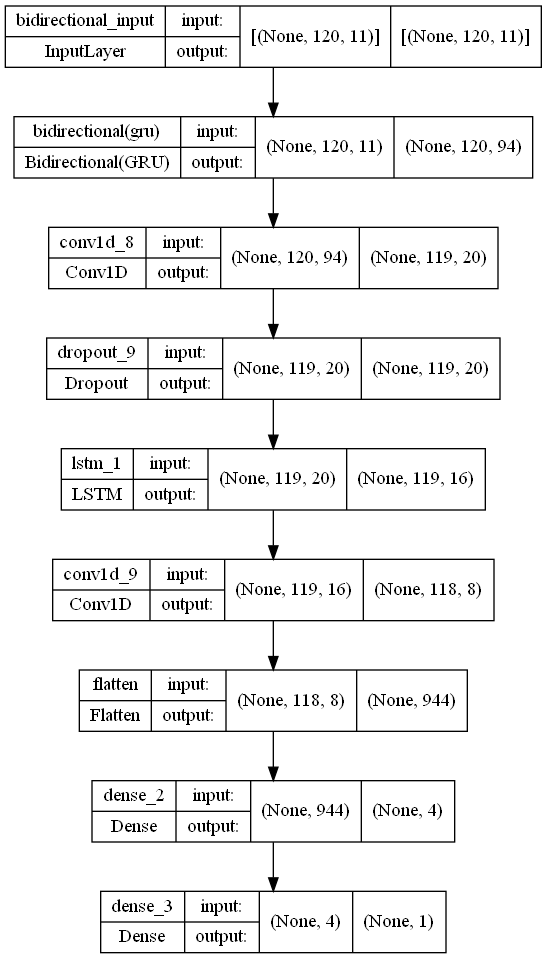

In [16]:
# from keras.utils.vis_utils import plot_model
# plot_model(model1, to_file='transformer_model_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(model, to_file='bi_model_plot.png', show_shapes=True, show_layer_names=True)



In [17]:
mse = model1.evaluate(xtest, ytest, verbose=1)
msd=model.evaluate(xtest, ytest, verbose=1)
print("transformers", mse)
print("bi-lstm", msd)
# Mean Squared Error: [0.049819089472293854, 0.17464657127857208] <----- standardScaler()
# Mean Squared Error: [0.027022255584597588, 0.09141747653484344]<----- MinMaxScaler()
# Mean Squared Error: [0.0231696255505085, 0.06953272223472595]<------ using ohlc

# Mean Squared Error: [0.030867109075188637, 0.14459161460399628]<------- 1hour
# Mean Squared Error: [0.019924916326999664, 0.09962350130081177] <------ sdg
# Mean Squared Error: [0.029022160917520523, 0.1379862129688263]
# Mean Squared Error: [0.021181577816605568, 0.05693402141332626]<------ using ohlc and predicting ohlc
# Mean Squared Error: [0.013695263303816319, 0.09310127794742584, 0.0009837677935138345]

87/87 [==============================] - 2s 15ms/step - loss: 0.0747 - root_mean_squared_error: 0.2655 - mean_absolute_error: 0.2278
transformers [0.012091964483261108, 0.10996346920728683, 0.08690712600946426]
bi-lstm [0.07469510287046432, 0.26551932096481323, 0.22782926261425018]


In [18]:
xtest.shape[2]

11

In [19]:
y_pred = model.predict(xtest)
y_pred1 = model1.predict(xtest)
# y_true=np.reshape(ytest, (ytest.shape[0], o)) 
y_true=ytest


In [20]:
y_pred.shape

(2760, 1)

In [21]:
def getinversescaler(pred,Sc):
    forcaste=np.repeat(pred,maincolumn,axis=1)
   
    forcaste=forcaste[:,:maincolumn]
    
    pred=Sc.inverse_transform(forcaste)
   
    return pred


In [22]:
dt=np.array(dt)


In [23]:
len(xtsl)

2760

In [24]:
xtsl=np.reshape(np.array(xtsl),(ytest.shape[0],1))

In [25]:
xtsl.shape

(2760, 1)

In [26]:
y_true.shape

(2760, 1)

In [27]:
true=getinversescaler(y_true,Sc=scaler)
pred=getinversescaler(y_pred,Sc=scaler)
pred1=getinversescaler(y_pred1,Sc=scaler)
xtsl=getinversescaler(xtsl,Sc=scaler)

In [28]:
# temp_df={"y_pred":pred[:,0],"y_true":true[:,0],"dates":dt[:,0],"p1":pred1[:,0],"t2":true1[:,0]}
temp_df={"y_pred":pred[:,0],"y_pred1":pred1[:,0],"y_true":true[:,0],"dates":dt[:],"xlast":xtsl[:,0]}
temp_df=pd.DataFrame.from_dict(temp_df)
temp_df=temp_df.set_index("dates")
temp_df

,y_pred,y_pred1,y_true,xlast
dates,,,,
2021-11-23 09:00:00+00:00,1.364574,1.343645,1.338043,1.338025
2021-11-23 10:00:00+00:00,1.364320,1.343821,1.336112,1.338043
2021-11-23 11:00:00+00:00,1.364187,1.344406,1.335702,1.336112
2021-11-23 12:00:00+00:00,1.364278,1.344936,1.334971,1.335702
2021-11-23 13:00:00+00:00,1.364468,1.345857,1.336881,1.334971
...,...,...,...,...
2022-05-04 04:00:00+01:00,1.318704,1.289700,1.248408,1.249063
2022-05-04 05:00:00+01:00,1.318954,1.291699,1.248377,1.248408
2022-05-04 06:00:00+01:00,1.319211,1.290174,1.247879,1.248377


In [29]:
# temp_df["model1 acc"]=temp_df['y_pred1']/np.abs(temp_df["y_pred1"]+temp_df['y_true'])
# temp_df["model acc"]=temp_df['y_pred']/np.abs(temp_df["y_pred"]+temp_df['y_true'])


In [30]:
temp_df.head()

,y_pred,y_pred1,y_true,xlast
dates,,,,
2021-11-23 09:00:00+00:00,1.364574,1.343645,1.338043,1.338025
2021-11-23 10:00:00+00:00,1.364320,1.343821,1.336112,1.338043
2021-11-23 11:00:00+00:00,1.364187,1.344406,1.335702,1.336112
2021-11-23 12:00:00+00:00,1.364278,1.344936,1.334971,1.335702
2021-11-23 13:00:00+00:00,1.364468,1.345857,1.336881,1.334971


In [31]:
import plotly.express as px
df=temp_df
fig = px.line(df, y=df.columns)

fig.show()
# fig=px.figure()
# fig.add_scattergl(x=temp_df.index.tolist(), y=temp_df["y_pred"], line={'color': 'black'})

# # Above threshhgold
# fig.add_scattergl(x=xs, y=df.y.where(df.y >= 1), line={'color': 'red'})

In [32]:
# y_true=yval
# # y_true= np.reshape(y_true, (y_true.shape[0], 1))
# # forcaste=np.repeat(y_pred,vtable.shape[1],axis=1)
# # real=np.repeat(y_true,vtable.shape[1],axis=1)
# y_pred=y_pred[:,0]
# y_true=scaler.inverse_transform(yval)[:,0]
fig = px.line(data, y=["Close","MA"])

fig.show()

In [33]:
d=np.array(xtest[-1:])
d.shape

(1, 120, 11)

In [34]:
def getss(ticker="gbpusd=x",ppp=25):
    li=["Adj Close","Volume","Open","High","Low"] if o==1 else ["Adj Close","Volume"]
    # data = yf.download(tickers=ticker+"=X",period="730d" ,interval="1h",progress=True)
    data = yf.download(tickers=ticker,period="15d" ,interval="1h",progress=True)
    # data=data.drop(["Adj Close","Volume"],axis=1)
    data=data.drop(li,axis=1)


    data=technicalIndicators(data)
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    print(data.shape)
    return data[:-ppp],data[-ppp:]

In [35]:
# model1 = tf.keras.models.load_model('models/{}-{}'.format("transformer","1h"))
# model=tf.keras.models.load_model('models/{}-{}'.format("bi-lstm","1h"))

In [36]:
next=5
newtable,check=getss("gbpusd=X",next)
newtable.shape
newtable1,check1=getss("gbpusd=X",next)

[*********************100%***********************]  1 of 1 completed
(240, 11)
[*********************100%***********************]  1 of 1 completed
(240, 11)


In [37]:

for i in range(next):
    X=newtable.iloc[-window_size:,:].copy(deep=True)
    X1=newtable1.iloc[-window_size:,:].copy(deep=True)
    Scalerc=MinMaxScaler()
    Scalerc1=MinMaxScaler()
    X.iloc[:,:]=Scalerc.fit_transform(X)[:,:]
    X1.iloc[:,:]=Scalerc1.fit_transform(X1)[:,:]
    Xn=np.asarray([X[:]])
    Xn1=np.asarray([X1[:]])
    last_date = newtable.iloc[[-1]].index
    last_date =  pd.DatetimeIndex(last_date) + pd.Timedelta(1,"h")
    ypredn = model.predict(Xn)
    ypredn1 = model1.predict(Xn1)
    ypredn=getinversescaler(ypredn,Scalerc)[0:]
    ypredn1=getinversescaler(ypredn1,Scalerc1)[0:]
    
    newtable=newtable.append(pd.DataFrame(ypredn,index=last_date,columns=newtable.columns.to_list()))
    newtable1=newtable1.append(pd.DataFrame(ypredn1,index=last_date,columns=newtable1.columns.to_list()))



C:\Users\harsh\AppData\Local\Temp\ipykernel_21756\1637682782.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_21756\1637682782.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_21756\1637682782.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_21756\1637682782.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\harsh\AppData\Local\Temp\ipykernel_21756\1637682782.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [38]:
newtable.tail()

,Close,MA,macd,macdsignal,macdhist,DEMA,EMA10,EMA30,MOM,ROC,KAMA
2022-05-04 04:00:00+01:00,1.255918,1.256063,0.001031,0.000806,0.000356,1.255235,1.256037,1.261259,0.006197,0.497496,1.255833
2022-05-04 05:00:00+01:00,1.255927,1.255510,0.001034,0.000852,0.000357,1.255242,1.255869,1.260914,0.006208,0.498398,1.255835
2022-05-04 06:00:00+01:00,1.255951,1.255335,0.001041,0.000858,0.000360,1.255263,1.255880,1.260628,0.006241,0.501043,1.255849
2022-05-04 07:00:00+01:00,1.255988,1.255258,0.001051,0.000867,0.000363,1.255294,1.255907,1.260419,0.006290,0.504951,1.255870
2022-05-04 08:00:00+01:00,1.256022,1.255073,0.001060,0.000875,0.000366,1.255322,1.255664,1.260107,0.006336,0.508568,1.255808


In [39]:
newtable1.tail()

,Close,MA,macd,macdsignal,macdhist,DEMA,EMA10,EMA30,MOM,ROC,KAMA
2022-05-04 04:00:00+01:00,1.258889,1.258512,0.001851,0.001535,0.000638,1.257736,1.258259,1.264000,0.010153,0.813688,1.257535
2022-05-04 05:00:00+01:00,1.261326,1.259733,0.002523,0.002122,0.000869,1.259788,1.259834,1.265752,0.013397,1.072969,1.258926
2022-05-04 06:00:00+01:00,1.263997,1.261823,0.003261,0.002750,0.001123,1.262037,1.261796,1.268146,0.016954,1.357285,1.260456
2022-05-04 07:00:00+01:00,1.268771,1.265556,0.004578,0.003873,0.001576,1.266056,1.265303,1.272424,0.023310,1.865316,1.263190
2022-05-04 08:00:00+01:00,1.276162,1.271337,0.006617,0.005611,0.002277,1.272278,1.270731,1.279046,0.033150,2.651794,1.267421


In [40]:
check.head()

,Close,MA,macd,macdsignal,macdhist,DEMA,EMA10,EMA30,MOM,ROC,KAMA
2022-05-04 04:00:00+01:00,1.248408,1.249671,-0.000556,-0.000509,-0.000048,1.248977,1.249581,1.250768,-0.005589,-0.445686,1.250942
2022-05-04 05:00:00+01:00,1.248377,1.249511,-0.000593,-0.000537,-0.000056,1.248723,1.249362,1.250614,-0.002248,-0.179764,1.250775
2022-05-04 06:00:00+01:00,1.247879,1.249272,-0.000655,-0.000576,-0.000079,1.248402,1.249093,1.250437,-0.003341,-0.267045,1.250419
2022-05-04 07:00:00+01:00,1.247801,1.249186,-0.000683,-0.000612,-0.000071,1.248132,1.248858,1.250267,-0.001200,-0.096083,1.250300
2022-05-04 07:24:37+01:00,1.247754,1.249039,-0.000683,-0.000636,-0.000048,1.247912,1.248657,1.250105,-0.002058,-0.164696,1.249961


In [41]:
check.Close[-10:]

2022-05-04 04:00:00+01:00    1.248408
2022-05-04 05:00:00+01:00    1.248377
2022-05-04 06:00:00+01:00    1.247879
2022-05-04 07:00:00+01:00    1.247801
2022-05-04 07:24:37+01:00    1.247754
Name: Close, dtype: float64

In [42]:
fig=px.line(newtable,y=["Close"])
fig.show()

In [43]:
df=newtable
# fig = px.line(x=df[-next:].index, y=[df["Close"][-next:],check["Close"]],)
fig = px.line(x=df[-next:].index, y=[df["Close"][-next:],newtable1["Close"][-next:],check["Close"]],)
series_names=["pred_model","true"]
for idx, name in enumerate(series_names):
    fig.data[idx].name = name
    # fig.data[idx].hovertemplate = name
# fig.add_trace(fig.add_scatter(x=check.index, y=check["Close"]))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [47]:
testingcontext={"Symbolname":"gbpusd","Cost":0.00015000000000000001,"pipval":0.0001,"Pridiction_size":4,"Open":[1.30074,1.3006,1.30051,1.29968,1.30047,1.29988,1.29969,1.30067,1.3015,1.30404,1.30287,1.30296,1.30166,1.3001,1.30023,1.29892,1.30099,1.3007,1.29996,1.29988,1.30024,1.29955,1.29973,1.30098,1.3014,1.30188,1.30284,1.30298,1.3041,1.30363,1.30295,1.30234,1.30009,1.30295,1.30312,1.30574,1.3052,1.3055,1.3052,1.30472,1.30536,1.30508,1.30577,1.30562,1.3063,1.30494,1.30573,1.30729,1.30668,1.30527],"High":[1.3019,1.30108,1.30067,1.30071,1.30095,1.30021,1.30109,1.30161,1.304,1.30408,1.30349,1.30298,1.30245,1.3005,1.30078,1.30121,1.30116,1.30149,1.3002,1.30028,1.30025,1.29987,1.30089,1.30144,1.30203,1.30308,1.30367,1.30452,1.30437,1.30366,1.30383,1.30234,1.30318,1.30415,1.30662,1.30616,1.30577,1.30655,1.30612,1.30589,1.30649,1.30579,1.30708,1.30652,1.3069,1.30644,1.30735,1.30733,1.30683,1.30527],"Low":[1.30024,1.30008,1.29892,1.29937,1.29932,1.29877,1.29885,1.30012,1.30114,1.30237,1.30143,1.30053,1.2997,1.29805,1.29879,1.29872,1.30017,1.2999,1.29918,1.29918,1.29964,1.29903,1.29973,1.30047,1.30115,1.3011,1.30234,1.30293,1.30334,1.30273,1.30162,1.30006,1.29963,1.30227,1.30304,1.30487,1.30327,1.30469,1.30343,1.30366,1.30462,1.30491,1.30533,1.30535,1.30614,1.30445,1.30573,1.30638,1.30468,1.30527],"Close":[1.3006,1.30052,1.29967,1.30047,1.29989,1.29972,1.30069,1.30149,1.304,1.30286,1.30296,1.30164,1.3001,1.30021,1.29894,1.30095,1.3007,1.29997,1.29989,1.30023,1.2999,1.29976,1.30089,1.30139,1.30188,1.30287,1.30294,1.30411,1.30363,1.30297,1.30234,1.30009,1.30294,1.30312,1.30574,1.30519,1.30549,1.3052,1.30471,1.30537,1.30506,1.30576,1.30563,1.30634,1.30678,1.30587,1.30727,1.30678,1.30525,1.30527]}

In [48]:
import pandas as pd
def getdataframe(context):
    data= pd.DataFrame({"Open":context["Open"],"High":context["High"],"Low":context["Low"],"Close":context["Close"]})
    data=technicalIndicators(data)
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    data.reset_index(inplace=True)
    data.drop("index",axis=1,inplace=True)

    return data
    
    



In [49]:
dff=getdataframe(testingcontext)

In [50]:
pip=0.0001

In [51]:
newtable=getdataframe(testingcontext)
next=2

In [52]:
maincolumn=25
def getpredictednew(next,data):
    newtable=data.copy(deep=True)
    for i in range(next):
        X=newtable.iloc[-window_size:,:].copy(deep=True)
        # X1=newtable1.iloc[-window_size:,:].copy(deep=True)
        Scalerc=MinMaxScaler()
        # Scalerc1=MinMaxScaler()
        X.iloc[:,:]=Scalerc.fit_transform(X)[:,:]
        # X1.iloc[:,:]=Scalerc1.fit_transform(X1)[:,:]
        Xn=np.asarray([X[:]])
        # Xn1=np.asarray([X1[:]])
        # last_date = newtable.iloc[[-1]].index
        # last_date =  pd.DatetimeIndex(last_date) + pd.Timedelta(1,"h")
        ypredn = model.predict(Xn)
        # ypredn1 = model1.predict(Xn1)
        ypredn=getinversescaler(ypredn,Scalerc)[0:]
        # ypredn1=getinversescaler(ypredn1,Scalerc1)[0:]
        newtable=newtable.append(pd.DataFrame(ypredn,index=newtable.iloc[-1:].index+1,columns=newtable.columns.to_list()))
        # newtable1=newtable1.append(pd.DataFrame(ypredn1,index=last_date,columns=newtable1.columns.to_list()))
    return newtable


In [53]:
newtable=getpredictednew(4,newtable)

ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by MinMaxScaler.

In [222]:
fig=px.line(newtableo,y=["Close"])
fig.show()

In [227]:
newtable.columns

Index(['Open', 'High', 'Low', 'Close', 'MA', 'Close_wave', 'High_wave',
       'Low_wave', 'Open_wave', 'macd', 'macdsignal', 'macdhist', 'CCI14',
       'ATR14', 'NATR14', 'DEMA', 'BBupper', 'BBmidle', 'BBlower', 'EMA10',
       'EMA30', 'MOM', 'ROC', 'KAMA', 'WillR'],
      dtype='object')

In [206]:
pred=newtable[-4:-3].Close.values[0]
pred1=newtable[-1:].Close.values[0]

In [210]:
30*pip*0.1

0.00030000000000000003

In [209]:
abs(pred-pred1)

0.00042569637298583984

In [208]:
abs(pred-pred1)>30*pip

False